In [ ]:
!mkdir Hurricane_Harvey
!mkdir Hurricane_Harvey/rasters 
!mkdir Hurricane_Harvey/vectors

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!gsutil -m cp -n -r gs://geoengine-dataset-houston-uav/rasters/raw Hurricane_Harvey/rasters/

In [ ]:
!gsutil -m cp -n -r gs://geoengine-dataset-houston-uav/vectors/random-split-_2022_11_17-22_35_45/ Hurricane_Harvey/vectors/

# Study of data

In [ ]:
#This code is just to form a list (train) with all image names to be used to training , rest are test images that do not have corresponding masks
import csv
import numpy as np
train_img=[]
with open('/content/drive/MyDrive/Hurricane_Harvey/vectors/random-split-_2022_11_17-22_35_45/CSV/train.csv','r') as fp:
    file = csv.DictReader(fp)
    for row in file:
        x = row['image:01'].split('/')[-1]
        y = x.split('.')[0]
        train_img.append(y)
k = np.array(train_img)
train = np.unique(k)
print(train)

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
pd.read_csv('/content/drive/MyDrive/Hurricane_Harvey/vectors/random-split-_2022_11_17-22_35_45/CSV/val.csv')

,Unnamed: 0,image-id,image:01,date:01,type,geometry,label


In [ ]:
print(len(train))

299


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Hurricane_Harvey/vectors/random-split-_2022_11_17-22_35_45/CSV/train.csv', header = 'infer')
df.drop('Unnamed: 0', inplace = True, axis = 1)

In [ ]:
df.columns

Index(['image-id', 'image:01', 'date:01', 'type', 'geometry', 'label'], dtype='object')

In [ ]:
df.iloc[0,1]

'gs://geoengine-dataset-houston-uav/rasters/7194.tif'

In [ ]:
df.label.value_counts()

Trees / Shrubs                             9644
Grass                                      4403
Property Roof                              1934
Vehicle                                    1697
Window                                      892
Chimney                                     821
Secondary Structure                         457
Parking Area                                427
Swimming Pool                               359
Power Lines & Cables                        287
Flooded                                     277
Road / Highway                              266
Street Light                                237
Dense Vegetation / Forest                   195
Garbage Bins                                153
Water Body                                   82
Satellite Antenna                            74
Trampoline                                   72
Solar Panels                                 52
Parking Area - Commercial                    45
Under Construction / In Progress Status 

# Data-PreProcessing

In [ ]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import os
import glob
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import imageio

import time

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
# Hyperparameters
HEIGHT = 320
WIDTH  = 320

In [ ]:
# os.mkdirs(f"Hurricane_Harvey/data_{HEIGHT}/train_images_{HEIGHT}")

In [ ]:
!mkdir /content/drive/MyDrive/Hurricane_Harvey/data
!mkdir /content/drive/MyDrive/Hurricane_Harvey/data/train_images_320
!mkdir /content/drive/MyDrive/Hurricane_Harvey/data/train_masks_320
!mkdir /content/drive/MyDrive/Hurricane_Harvey/data/val_images_320
!mkdir /content/drive/MyDrive/Hurricane_Harvey/data/val_masks_320
!mkdir /content/drive/MyDrive/Hurricane_Harvey/data/test_images_320

mkdir: cannot create directory ‘/content/drive/MyDrive/Hurricane_Harvey/data’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/Hurricane_Harvey/data/train_images_320’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/Hurricane_Harvey/data/train_masks_320’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/Hurricane_Harvey/data/val_images_320’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/Hurricane_Harvey/data/val_masks_320’: File exists


In [ ]:
!mkdir Hurricane_Harvey/data/models

In [ ]:
root = os.getcwd()
train_img_link_list  = sorted(glob.glob('/content/drive/MyDrive/Hurricane_Harvey/New_Train/Images/*'))
train_mask_link_list = sorted(glob.glob('/content/drive/MyDrive/Hurricane_Harvey/New_Train/Masks/*'))
test_img_link_list   = sorted(glob.glob('/content/drive/MyDrive/Hurricane_Harvey/New_Test/Images/*'))

In [ ]:
print(test_img_link_list[1])

/content/drive/MyDrive/Hurricane_Harvey/New_Test/Images/10300.tif


In [ ]:
val_img_list = [6414,6420,6433,6444,6468,6556,6565,6640,6715,7691,8368,8447,8817,8902,7233,
                6706,7256,7315,7321,7336,7525,7575,8917,8955,9107,6820,6843,6905,6966,6969]
val_img_list = [str(x) for x in val_img_list]

In [ ]:
import cv2
import os
img_dir = '/content/drive/MyDrive/Hurricane_Harvey/rasters/raw'
diff_img = []
x=0
for path, subdirs, files in os.walk(img_dir): 
    dirname = path.split(os.path.sep)[-1]
    images = os.listdir(path)  #List of all image names in this subdirectory
    for i, image_name in enumerate(images):
        if image_name.endswith(".tif"):
            if image_name[:-4] in train:
                continue
            else:
                t_image = cv2.imread(path+"/"+image_name, 1)  #Read each image as RBG
                if t_image.shape == (3000, 4000, 3):
                  diff_img.append(image_name[:-4])

In [ ]:
print((diff_img))

['10184', '10300', '6414', '6427', '6447', '6456', '6469', '6499', '6548', '6569', '6639', '6645', '6649', '6659', '6703', '6794', '6796', '6820', '6829', '6933', '6939', '6946', '6979', '7298', '7473', '7650', '7691', '7751', '7899', '8362', '8431', '8447', '8777', '8786', '8821', '8860', '8955', '9036', '9045', '9079', '9080', '9082', '9055', '9103', '9795']


In [ ]:
print(len(train_img_link_list))
print(len(train_mask_link_list))
print(len(test_img_link_list))
print(train_img_link_list[0])

299
299
75
/content/drive/MyDrive/Hurricane_Harvey/New_Train/Images/10170.tif


In [ ]:
# Transformation pipeline
transform_img = transforms.Compose([
    transforms.Resize([HEIGHT,WIDTH]),
    transforms.ToTensor()
])

transform_mask = transforms.Compose([
    transforms.Resize([HEIGHT,WIDTH], interpolation=Image.NEAREST),
    transforms.ToTensor()
])

transform_mask_prova = transforms.Compose([
    transforms.ToTensor()
])

# Iterate through all masks and images in train set, transform them and store corresponging tensors in a new folder
for i in tqdm(range(len(train_img_link_list))):
    
    img_id  = train_img_link_list[i].split('/')[-1].split('.')[0]
    mask_id = train_mask_link_list[i].split('/')[-1].split('.')[0]
    assert img_id == mask_id    # Making sure that the names match
    
    img   = Image.open(train_img_link_list[i])
    mask  = Image.open(train_mask_link_list[i])

    img  = transform_img(img)
    mask = transform_mask(mask)*255
    mask = mask.int()
    
    if img_id in val_img_list:
        torch.save(img, f'/content/drive/MyDrive/Hurricane_Harvey/data/val_images_{HEIGHT}/{img_id}.pt')
        torch.save(mask, f'/content/drive/MyDrive/Hurricane_Harvey/data/val_masks_{HEIGHT}/{mask_id}.pt')
    else:
        torch.save(img, f'/content/drive/MyDrive/Hurricane_Harvey/data/train_images_{HEIGHT}/{img_id}.pt')
        torch.save(mask, f'/content/drive/MyDrive/Hurricane_Harvey/data/train_masks_{HEIGHT}/{mask_id}.pt')
    
print('Train and Validation sets created')
    

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
100%|██████████| 299/299 [08:34<00:00,  1.72s/it]

Train and Validation sets created


In [ ]:
# Iterate through all images in test set, transform them and store corresponging tensors in a new folder
for i in tqdm(range(len(test_img_link_list))):
    
    img_id  = test_img_link_list[i].split('/')[-1].split('.')[0]
    
    img   = Image.open(test_img_link_list[i])
    img   = transform_img(img)
    torch.save(img, f'/content/drive/MyDrive/Hurricane_Harvey/data/test_images_{HEIGHT}/{img_id}.pt')
print('Test set created')

test_dataloader = DataLoader()

100%|██████████| 75/75 [01:26<00:00,  1.15s/it]

Test set created


In [ ]:
#adding more augmentations for images of minority classes (which have les number of images in train dataset)
#Creating additional samples
min_classses = [20, 18, 17, 25, 21]
count = 0

for i in tqdm(range(len(train_img_link_list))):
    
    img_id  = train_img_link_list[i].split('/')[-1].split('.')[0]
    mask_id = train_mask_link_list[i].split('/')[-1].split('.')[0]
    assert img_id == mask_id    # Making sure that the names match
    
    img   = Image.open(train_img_link_list[i])
    mask  = Image.open(train_mask_link_list[i])

    img  = transform_img(img)
    mask = transform_mask(mask)*255
    mask = mask.int()

    if len(set(min_classses).intersection(set(mask.unique().tolist()))) > 0:

        cropped_img = T.FiveCrop(size=(HEIGHT//2,WIDTH//2))(img)
        cropped_mask = T.FiveCrop(size=(HEIGHT//2,WIDTH//2))(mask)
        
        for y in range(5):
            list_mask = [o_items for sublist in cropped_mask[y].tolist() for o_items in sublist]
            if any(items in min_classses for items in [o_items for sublist in list_mask for o_items in sublist]):
                
                mask_in_progress = transform_mask_prova(np.array([cropped_mask[y][0].tolist()]))
                
                torch.save(TF.resize(cropped_img[y], size=(HEIGHT, WIDTH)), f'/content/drive/MyDrive/Hurricane_Harvey/data/train_images_{HEIGHT}/PLUS_{img_id}_{y}.pt')
                torch.save(TF.resize(mask_in_progress.permute(1,2,0), size=(HEIGHT, WIDTH)), f'/content/drive/MyDrive/Hurricane_Harvey/data/train_masks_{HEIGHT}/PLUS_{img_id}_{y}.pt')
                count += 1
                
print('Additional', count, ' samples created')
# 100

100%|██████████| 299/299 [02:15<00:00,  2.21it/s]

Additional 38  samples created


In [ ]:
# Data preparation Hyperparameters
NUM_CLASSES = 27
TRAIN_VAL_SPLIT = 0.8
BATCH_SIZE = 8
HEIGHT = 320    # In this implementation height and width both need to be divisible by 16
WIDTH  = 320

In [ ]:
# Create a custom Dataset class

class tensorDataset(Dataset):
    
    def __init__(self, images:list, masks:list, train:bool):
        self.image_links = images
        self.mask_links  = masks
        self.train = train
        

    def __getitem__(self, index):
        
        # Select a specific image's link
        img_id  = self.image_links[index]
        mask_id = self.mask_links[index]

        # Load the image (as tensor)
        img  = torch.load(img_id)
        mask = torch.load(mask_id)
        
        # Apply transformations
        if self.train == True:
          img, mask = self.transform(img, mask)
        
        # Squeeze mask from (1, H, W) to (H, W) -> This is because loss function accepts (B, H, W)
        mask = mask.squeeze(0)

        # Turn on gradient for image
        img = img.detach().clone().requires_grad_(True)
        mask = mask.long()
        
        return img, mask

    
    def __len__(self):
        return len(self.image_links)
    
    
    def transform(self, img, mask):
        
        # Some images in the test set are much brighter/darker than others
        temp_rand = np.random.rand()
        if temp_rand < 0.3:
            t_darken_image = T.ColorJitter(brightness=[0.6, 0.8])
            img = t_darken_image(img)
            # Do nothing for mask - the colors don't change
        elif temp_rand > 0.7:
            t_brighten_image = T.ColorJitter(brightness=[1.2, 1.4])
            img = t_brighten_image(img)
            # Do nothing for mask - the colors don't change
        
        # Flipping images makes sense for satelite images
        if np.random.rand() < 0.3:
            t_horizonal_flip = T.RandomHorizontalFlip(p=1)
            img = t_horizonal_flip(img)
            mask = t_horizonal_flip(mask)
            
        if np.random.rand() < 0.3:
            t_vertical_flip = T.RandomVerticalFlip(p=1)
            img  = t_vertical_flip(img)
            mask = t_vertical_flip(mask)

        # Add rotations
        if np.random.rand() < 0.3:
          t_rotation = T.RandomRotation(degrees=(0, 180))
          img = t_rotation(img)
          mask = t_rotation(mask)


        return img, mask

In [ ]:
# Specify paths to your files (glob glob stores paths to all files in a folder in a list)
train_img_link_list  = sorted(glob.glob('/content/drive/MyDrive/Hurricane_Harvey/data/train_images_320/*'))
train_mask_link_list = sorted(glob.glob('/content/drive/MyDrive/Hurricane_Harvey/data/train_masks_320/*'))
val_img_link_list    = sorted(glob.glob('/content/drive/MyDrive/Hurricane_Harvey/data/val_images_320/*'))
val_mask_link_list   = sorted(glob.glob('/content/drive/MyDrive/Hurricane_Harvey/data/val_masks_320/*'))

train_dataset = tensorDataset(train_img_link_list, train_mask_link_list, train=True)
val_dataset   = tensorDataset(val_img_link_list, val_mask_link_list, train=False)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader   = DataLoader(val_dataset  , batch_size=BATCH_SIZE, shuffle=False)

# Modelling

In [ ]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import os
import glob
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import imageio

import time
from tqdm import tqdm

import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt

In [ ]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [ ]:
# Define a function to calculate the Dice score
def f1_dice_score(preds, true_mask):
  
    f1_batch = []

    for i in range(len(preds)):
        f1_image = []
        img  = preds[i].to(DEVICE)
        mask = true_mask[i].to(DEVICE)
        
        # Change shape of img from [25, H, W] to [H, W]
        img = torch.argmax(img, dim=0)
    
        for label in range(27):
            if torch.sum(mask == label) != 0:
                area_of_intersect = torch.sum((img == label) * (mask == label))
                area_of_img       = torch.sum(img == label)
                area_of_label     = torch.sum(mask == label)
                f1 = 2*area_of_intersect / (area_of_img + area_of_label)
                f1_image.append(f1)
        
        f1_batch.append(np.mean([tensor.cpu() for tensor in f1_image]))
    return np.mean(f1_batch)
    
    
# Accuracy
def accuracy(preds, true_mask):

    accuracy_batch = []

    for i in range(len(preds)):
        img  = preds[i].to(DEVICE)
        mask = true_mask[i].to(DEVICE)
        
        # Change shape of img from [25, H, W] to [H, W]
        img  = torch.argmax(img, dim=0)
        
        accuracy_batch.append(torch.sum(img == mask).item() / (HEIGHT*WIDTH))  # FIX LATER
        
    return np.mean(accuracy_batch)


In [ ]:
def train():

  min_val_f1 = 0.3

  for epoch in range(STARTING_EPOCH+1, STARTING_EPOCH+EPOCHS+1):
      
      # Train model
      model.train()
      train_losses   = []
      train_accuracy = []
      train_f1       = []

      print(epoch)
      for i, batch in enumerate(train_dataloader):
          #Extract data, labels
          img_batch, mask_batch = batch   
          img_batch = img_batch.to(DEVICE)
          mask_batch = mask_batch.to(DEVICE)

          #Train model
          optimizer.zero_grad()
          # with torch.cuda.amp.autocast():
          output = model(img_batch)
          loss   = criterion(output, mask_batch)
          loss.backward()

          # torch.nn.utils.clip_grad_norm_(model.parameters(), 6)
          optimizer.step()

          #Add current loss to temporary list (after 1 epoch take avg of all batch losses)
          f1 = f1_dice_score(output, mask_batch)
          acc = accuracy(output, mask_batch)
          train_losses.append(loss.item())
          train_accuracy.append(acc)
          train_f1.append(f1)
        
      
      # Update global metrics
      print(f'TRAIN       Epoch: {epoch} | Epoch metrics | loss: {np.mean(train_losses):.4f}, f1: {np.mean(train_f1):.3f}, accuracy: {np.mean(train_accuracy):.3f}')        
      total_train_losses.append(np.mean(train_losses))
      total_train_accuracy.append(np.mean(train_accuracy))
      total_train_f1.append(np.mean(train_f1))
      
      
      # Validate model
      model.eval()
      val_losses   = []
      val_accuracy = []
      val_f1       = []
      
      for i, batch in enumerate(val_dataloader):
          #Extract data, labels
          img_batch, mask_batch = batch
          img_batch = img_batch.to(DEVICE)
          mask_batch = mask_batch.to(DEVICE)

          #Validate model
          with torch.cuda.amp.autocast():
            output = model(img_batch)
            loss   = criterion(output, mask_batch)

          #Add current loss to temporary list (after 1 epoch take avg of all batch losses)
          f1 = f1_dice_score(output, mask_batch)
          acc = accuracy(output, mask_batch)
          val_losses.append(loss.item())
          val_accuracy.append(acc)
          val_f1.append(f1)
          
      
      
      # Update global metrics
      print(f'VALIDATION  Epoch: {epoch} | Epoch metrics | loss: {np.mean(val_losses):.4f}, f1: {np.mean(val_f1):.3f}, accuracy: {np.mean(val_accuracy):.3f}')
      print('---------------------------------------------------------------------------------')
      total_val_losses.append(np.mean(val_losses))
      total_val_accuracy.append(np.mean(val_accuracy))
      total_val_f1.append(np.mean(val_f1))
      
      
      # Save the model
      if np.mean(val_f1) > min_val_f1:
        torch.save(model.state_dict(), f'/content/drive/MyDrive/Hurricane_Harvey/data/models/dlv3+_resnet101_320_{epoch}.pt')
        min_val_f1 = np.mean(val_f1)
      
      # Save the results so far
      temp_df = pd.DataFrame(list(zip(total_train_losses, total_val_losses, total_train_f1, total_val_f1,
                                    total_train_accuracy, total_val_accuracy)),
                            columns = ['train_loss', 'val_loss', 'train_f1', 'test_f1', 'train_accuracy',
                                      'test_accuracy'])
      temp_df.to_csv('train_val_measures')

  torch.save(model.state_dict(), f'/content/drive/MyDrive/Hurricane_Harvey/data/models/dlv3+_main_resnet101_320_{EPOCHS}.pt')


In [ ]:
from torch.nn.modules.activation import Softmax2d

# model = smp.UnetPlusPlus(
#     encoder_name = 'efficientnet-b6', 
#     encoder_weights = 'imagenet', 
#     classes = 27, 
#     activation = Softmax2d,
# ).to(DEVICE)

# model = smp.UnetPlusPlus(
#     encoder_name = 'resnet34', 
#     encoder_weights = 'imagenet', 
#     classes = 27, 
#     activation = Softmax2d,
# ).to(DEVICE)

# model = smp.DeepLabV3Plus(
#     encoder_name = 'efficientnet-b7', 
#     encoder_weights = 'imagenet', 
#     classes = 27, 
#     activation = None, # could be None for logits or 'softmax2d' for multiclass segmentation
# ).to(DEVICE)

model = smp.DeepLabV3Plus(
    encoder_name = 'resnet101', 
    encoder_weights = 'imagenet', 
    classes = 27, 
    activation = None, 
).to(DEVICE)

total_train_losses   = []
total_val_losses     = []
total_train_accuracy = []
total_val_accuracy   = []
total_train_f1       = []
total_val_f1         = []

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

In [ ]:
# HYPERPARAMETERS for training run
STARTING_EPOCH = 0
EPOCHS = 150
LR = 0.000001

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss().to(DEVICE)

train()

1
TRAIN       Epoch: 1 | Epoch metrics | loss: 3.2132, f1: 0.021, accuracy: 0.071
VALIDATION  Epoch: 1 | Epoch metrics | loss: 3.1782, f1: 0.057, accuracy: 0.099
---------------------------------------------------------------------------------
2
TRAIN       Epoch: 2 | Epoch metrics | loss: 3.1149, f1: 0.030, accuracy: 0.122
VALIDATION  Epoch: 2 | Epoch metrics | loss: 3.0701, f1: 0.091, accuracy: 0.194
---------------------------------------------------------------------------------
3
TRAIN       Epoch: 3 | Epoch metrics | loss: 3.0119, f1: 0.041, accuracy: 0.194
VALIDATION  Epoch: 3 | Epoch metrics | loss: 3.0361, f1: 0.120, accuracy: 0.297
---------------------------------------------------------------------------------
4
TRAIN       Epoch: 4 | Epoch metrics | loss: 2.9039, f1: 0.052, accuracy: 0.274
VALIDATION  Epoch: 4 | Epoch metrics | loss: 2.8429, f1: 0.140, accuracy: 0.382
---------------------------------------------------------------------------------
5
TRAIN       Epoch: 5 |

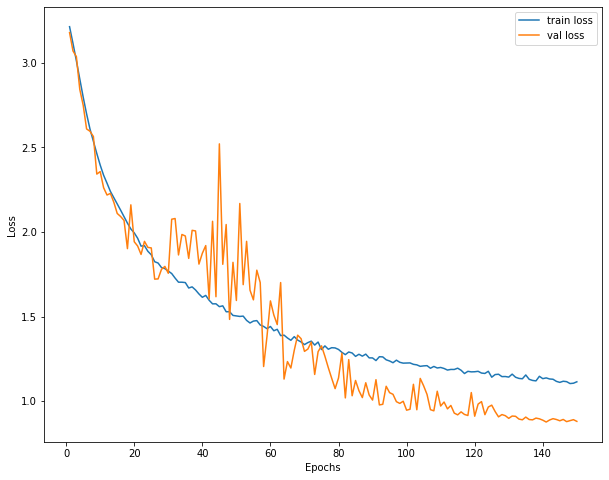

In [ ]:
#Plot Train and Val loss curves
plt.figure(figsize=(10,8))
plt.plot(list(range(len(total_train_losses)+1))[1:160], total_train_losses[:160])
plt.plot(list(range(len(total_train_losses)+1))[1:160], total_val_losses[:160])
plt.legend(['train loss', 'val loss', 'val f1'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Present vs Predicted Masks

In [ ]:
# Get a batch from validation set
img, mask = next(iter(val_dataloader))
model.cpu()
img = img
output = model(img)

In [ ]:
from matplotlib import colors

# Define function for plotting images
def show_random_images(i, img, output, true_mask):

    # Get preiction from output
    pred_mask  = torch.argmax(output, dim=1)
    
    # Get one image/mask only from the list, based on passed index 'i'
    img = img[i].cpu()
    pred_mask = pred_mask[i].cpu()
    true_mask = true_mask[i].cpu()
    
    # Add dummy pixels in the top left <- ensures colors assigned to each class by matplotlib match in both masks
    for i in range(24):
      pred_mask[0][i] = i
      true_mask[0][i] = i

    # Plot
    f, axarr = plt.subplots(1,3, figsize=(25,20))
    axarr[0].imshow(img.permute(1,2,0).detach().numpy())
    axarr[1].imshow(true_mask, cmap='tab20')
    axarr[2].imshow(pred_mask, cmap='tab20')

    plt.show()

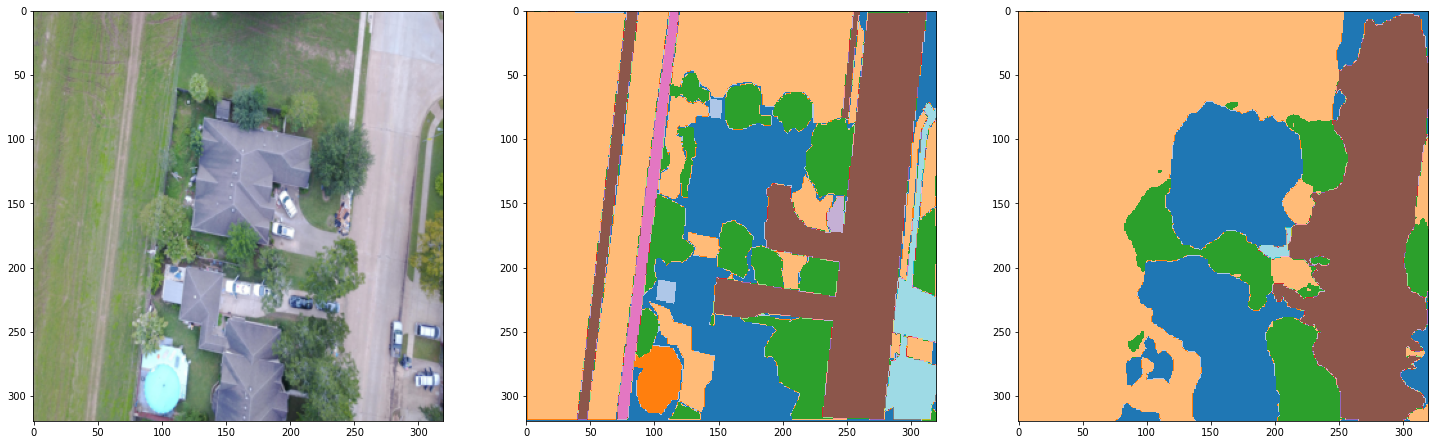

In [ ]:
show_random_images(1, img, output, mask)

# Loading Model

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Load the best model
model = smp.DeepLabV3Plus(
    encoder_name = 'resnet101', 
    encoder_weights = 'imagenet', 
    classes = 27, 
    activation = None, # could be None for logits or 'softmax2d' for multiclass segmentation
)

model.load_state_dict(torch.load('/content/drive/MyDrive/Hurricane_Harvey/data/models/dlv3+_main_resnet101_320_150.pt'))

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

<All keys matched successfully>

# Prediction

In [ ]:
# Load test images
test_img_link_list = sorted(glob.glob('/content/drive/MyDrive/Hurricane_Harvey/data/test_images_320/*'))
torch_list = [torch.load(link) for link in test_img_link_list]

In [ ]:
#To check number of images in test dataset
temp = sorted(glob.glob('/content/drive/MyDrive/Hurricane_Harvey/data/test_images_320/*'))
len(temp)

75

In [ ]:
model.eval()

# calculate output for each image in test set and save the prediction in new folder
for i in tqdm.tqdm(range(len(torch_list))):
  img_id = test_img_link_list[i].split('/')[-1].split('.')[0]
  img = torch_list[i].unsqueeze(0)
  # img = img.to(DEVICE)
  output = model(img)
  # output=output.to(DEVICE)
  output = torch.argmax(output, dim=1).squeeze(0)
  output = np.uint8(output)
  output = Image.fromarray(output)
  output.save(f"/content/drive/MyDrive/Hurricane_Harvey/New_Test/Pred/{img_id}.png")

100%|██████████| 75/75 [00:30<00:00,  2.44it/s]


In [ ]:
# CHECK 2: how many predicted images in folder
temp = sorted(glob.glob('/content/drive/MyDrive/Hurricane_Harvey/New_Test/Pred/*'))
len(temp)

75

#Resizing masks back to original image sizes

In [ ]:
test_mask_dir = '/content/drive/MyDrive/Hurricane_Harvey/New_Test/Pred/'
test_masks=[]
std_dim = (4000 , 3000)
diff_dim = (4592, 3072)
for path, subdirs, files in os.walk(test_mask_dir): 
    dirname = path.split(os.path.sep)[-1]
    masks = os.listdir(path)  #List of all image names in this subdirectory
    for i, mask_name in enumerate(masks):
            if mask_name.endswith(".png"):
                mask = cv2.imread(path+"/"+mask_name, 0)  #Read each image as BG
                if mask_name[:-4] in diff_img:
                  mask = cv2.resize(mask, std_dim, interpolation = cv2.INTER_NEAREST)
                else:
                  mask = cv2.resize(mask, diff_dim, interpolation = cv2.INTER_NEAREST)
                test_masks.append(mask)
                mask = np.array(mask)
                cv2.imwrite("/content/drive/MyDrive/Hurricane_Harvey/New_Test/Masks/"+mask_name,mask)    
print(len(test_masks)) 

75


#Creating tar file for submission

In [ ]:
final_test_dir = "/content/drive/MyDrive/Hurricane_Harvey/New_Test/Masks/"
import tarfile  

tar = tarfile.open("submission.tar", "w")  
for root, dir, files in os.walk(final_test_dir):
	for  file in files:
		fullpath = os.path.join(root, file)
		tar.add(fullpath, arcname=file)
tar.close()